
Bad key "text.kerning_factor" on line 4 in
C:\Users\nerpa\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


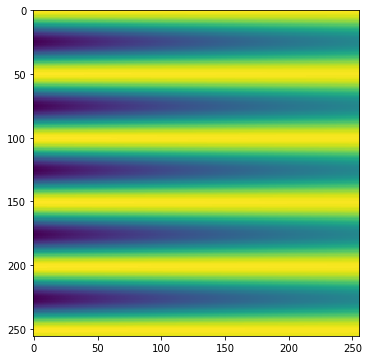

In [1]:
import numpy as np

from utils import save, load
from library import *
from process_library_terms import *
import matplotlib.pyplot as plt

#import h5py
#with h5py.File('NSE2D/uvp-0.001.mat', 'r') as mat:
#with h5py.File('NSE2D/uvp2-0.001.mat', 'r') as mat:
#with h5py.File('NSE2D/tgv-0.001.mat', 'r') as mat:
    #P = np.array(mat['P'])
    #U = np.array(mat['U'])
    #V = np.array(mat['V'])
    
#import netCDF4 as nc
#fn = '/path/to/file.nc4'
#ds = nc.Dataset(fn)

# for some reason, we need to fix the order of the axes
#P = np.transpose(P, (1, 2, 0))
#U = np.transpose(U, (1, 2, 0))
#V = np.transpose(V, (1, 2, 0))

Lx = 4; Ly = 4; Lt = 1;
#Nx = 512; Ny = Nx; Nt = 1000; # normal resolution
#Nx = 256; Ny = Nx; Nt = 1000; # half resolution
Nx = 256; Ny = Nx; Nt = Nx # analytical
dx = Lx/Nx; dy = Ly/Ny; dt = Lt/Nt;

# don't use MATLAB data
x = np.arange(0, 4, dx); y = np.arange(0, 4, dy); t = np.arange(0, 1, dt)
xg, yg = np.meshgrid(x, y)
U = 4*np.einsum('i,j,k->ijk', np.sin(4*x), np.cos(4*y), np.exp(-0.32*t))
V = -4*np.einsum('i,j,k->ijk', np.cos(4*x), np.sin(4*y), np.exp(-0.32*t))
P = 4*np.einsum('ij, k->ijk', np.cos(8*xg)+np.cos(8*yg), np.exp(-0.64*t))

fig, ax= plt.subplots(figsize=(6,6))
ax.imshow(P[:, 128, :])

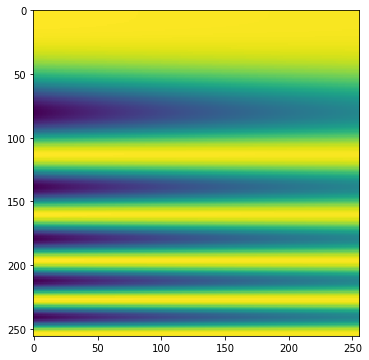

In [2]:
from utils import resample_grid

x_resample = np.arange(0, 4, dx)**2/4
P_res = resample_grid(P, x, x_resample, axis=0, order=5)
fig, ax= plt.subplots(figsize=(6,6))
diff = (P_res-P)[:, 128, :]
ax.imshow(P_res[:, 128, :])
#ax.imshow(diff)

0.00567823071366147

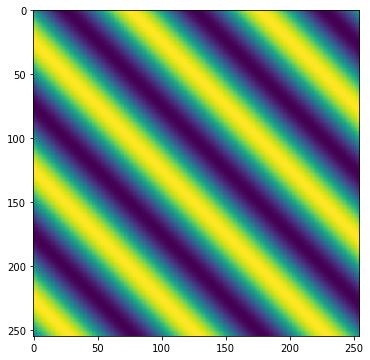

In [3]:
fig, ax= plt.subplots(figsize=(6,6))
dU = np.diff(U[:, :, -1], axis=0)
dV = np.diff(V[:, :, -1], axis=1)
ax.imshow(dU[:,1:]+dV[1:,:])
np.max(dU[:,1:]+dV[1:,:])

In [4]:
uobs = Observable('u', 1)
pobs = Observable('p', 0)
observables = [uobs, pobs]

u = np.concatenate([U[:, :, :, np.newaxis], V[:, :, :, np.newaxis]], axis=3)

### define all parameters and "make library"
terms = generate_terms_to(3, observables=observables, max_observables=3)
terms0 = []
terms1 = []
for term in terms:
    if term.rank==0:
        terms0.append(term)
    else:
        terms1.append(term)

world_size = np.array(U.shape)
m = 12
qmax = 1
nweights = qmax**4
ndomains = 30 #250
wx = 64
wt = 50
pad = 0


In [5]:
%%prun

# fix random seed
np.random.seed(1)

data_dict = {'p': P, 'u': u}

dxs = [dx, dy, dt]

scale_dict = find_scales(data_dict)

char_sizes0 = [get_char_size(term, scale_dict, dx, dt) for term in terms0]
char_sizes1 = [get_char_size(term, scale_dict, dx, dt) for term in terms1]

weights = []
dxs_weight = [(wx-1)/2*dx, (wx-1)/2*dx, (wt-1)/2*dt] # grid spacing used by weight function

#for domain in domains:
for q1 in range(qmax):
    for q2 in range(qmax):
        for q3 in range(qmax):
            for q4 in range(qmax):
                weights.append(Weight([m]*3, [q1, q2, q3], [0]*3, dxs=dxs_weight))
#domains = domains*nweights

# make domains and "count" density
domains = make_domains([wx, wx, wt], world_size, ndomains, pad)

Q0 = make_library(terms0, data_dict, weights, domains, 0, dxs, debug=False)#, by_parts=False)
Q1 = make_library(terms1, data_dict, weights, domains, 1, dxs, debug=False)#, by_parts=False)

         653272 function calls (623950 primitive calls) in 34.348 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4230    7.632    0.002    7.968    0.002 function_base.py:4129(trapz)
     1080    7.130    0.007    7.136    0.007 diff.py:478(_apply_to_array)
        2    7.104    3.552   33.809   16.905 process_library_terms.py:264(make_library)
     2010    4.087    0.002   18.650    0.009 process_library_terms.py:172(eval_term)
47561/22015    2.939    0.000   12.260    0.001 {built-in method numpy.core._multiarray_umath.implement_array_function}
     2010    1.693    0.001    5.252    0.003 process_library_terms.py:36(get_weight_array)
     6030    0.682    0.000    0.706    0.000 polynomial.py:664(polyval)
    18692    0.654    0.000    0.654    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      360    0.286    0.001    7.970    0.022 diff.py:277(diff)
     6030    0.268    0.000    0.691    0.000 function_base.

In [6]:
from identify_models import *

opts = dict()
opts['threshold'] = "'threshold'"
opts['gamma'] = 2
opts['verbose'] = False
opts['brute_force'] = False
opts['delta'] = 1e-8 # apparently this reaches machine precision as the relative error
opts['char_sizes'] = char_sizes0
#opts['n_terms'] = 3
opts1 = opts.copy()
opts1['char_sizes'] = char_sizes1
#eqs0, lambdas0, derived_eqs0, excluded_terms = identify_equations(Q0, opts, terms0, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True)
#print(excluded_terms)
#eqs1, lambdas1, derived_eqs1, excluded_terms = identify_equations(Q1, opts1, terms1, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True, excluded_terms=excluded_terms)
#print(excluded_terms)
eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([Q0, Q1], [opts, opts1], [terms0, terms1],
                                                        observables, threshold=1e-5)

#Identified model: 0.9999999997998261 * di p + 1.0 * dj u_i * u_j = 0 (order 3, residual 7.50e-09)
#Identified model: 0.9999999997998261 * di p + 1.0 * dj u_i * u_j = 0 (order 3, residual 2.08e-08)

[0.01 s]
Identified model: 1.0 * dt p + 0.6399999999993811 * p = 0 (order 2, residual 4.11e-16)
[0.02 s]
Identified model: 1.0 * dj u_j = 0 (order 2, residual 1.51e-13)
[0.00 s]
Identified model: 1.0 * dt u_i + 0.3199999999995415 * u_i = 0 (order 2, residual 1.50e-15)
[0.01 s]
Identified model: 0.01562500000000233 * dj^2 p + 1.0 * p = 0 (order 3, residual 4.21e-15)
[0.01 s]
Identified model: 0.03125000000004562 * dj^2 u_i + 1.0 * u_i = 0 (order 3, residual 5.37e-15)
[0.03 s]
Identified model: 0.999999999787291 * di p + -2.1270867392742196e-10 * u_j * di u_j + 1.0 * u_j * dj u_i = 0 (order 3, residual 1.09e-12)
[0.04 s]
Identified model: 0.9999999997877309 * di p + 5.39269567032929e-11 * p * di p + 1.0 * u_j * dj u_i = 0 (order 3, residual 6.72e-09)
[0.04 s]
Identified model: 0.9999999997998263 * di p + 1.0 * u_j * dj u_i = 0 (order 3, residual 1.79e-08)


In [7]:
from sparse_reg import *
#from ipynb.fs.full.sparse_reg import *
opts = dict()
#opts['threshold'] = "'pareto'"
#opts['verbose'] = True
#opts['brute_force'] = False
opts['threshold'] = "'threshold'"
opts['n_terms'] = len(terms0)
opts['gamma'] = 2
opts['verbose'] = False
opts['delta'] = 1e-8 #apparently this reaches machine precision as the relative error
opts['char_sizes'] = char_sizes0
#Xi, lambd, best_term, lambda1 = sparse_reg(Q0, opts)
Xi, lambd, best_term, lambda1 = sparse_reg(Q0, **opts)

In [8]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print(f"Best term (#{best_term}):", terms0[best_term])

[Term 12] 0.6399999999995278 * p * p
[Term 13] 1.0 * dt p * p
Model residual: 3.4526399424093805e-16
One-term model residual: 3.763842884454046e-14
Best term (#9): p * dj u_j


In [9]:
opts['char_sizes'] = char_sizes1
#Xi, lambd, best_term, lambda1 = sparse_reg(Q1, opts)
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, **opts)

In [10]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

[Term 11] 0.6400000000000264 * p * u_i
[Term 13] 1.0 * dt p * u_i
Model residual: 1.4120926536239347e-16
One-term model residual: 2.3816383670788472e-08
Best term: dj u_j * u_i


In [11]:
avoid = []
avoid.append(Xi)
opts['avoid'] = avoid
opts['verbose'] = False
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, **opts)
#Xi, lambd, best_term, lambda1 = sparse_reg(Q1, opts)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

[Term 11] 0.22701475595915035 * p * u_i
[Term 12] 1.0 * p * dt u_i
[Term 13] -0.14528944381386225 * dt p * u_i
Model residual: 3.629557285191519e-16
One-term model residual: 2.3816383670788472e-08
Best term: dj u_j * u_i


In [8]:
for term, size in zip(terms0, char_sizes0):
    print(term, size)
for term, size in zip(terms1, char_sizes1):
    print(term, size)

1 1
p 3.0301881069336614
dj^2 p 0.0005897077441099261
dt p 0.009435323905758818
dt^2 p 3.685673400687038e-05
p * p 9.182039963402206
p * dt p 0.02859080628429723
p * p * p 27.823308294490953
dj u_j 0.02158255447274597
dt dj u_j 8.430685340916395e-05
dj p * u_j 0.06490194419228748
p * dj u_j 0.06539919988056274
u_j * u_j 2.9572075294167512
u_j * dt u_j 0.00927862784513299
p * u_j * u_j 8.960895085373314
di p 0.03774129562303527
dt di p 0.00014742693602748152
p * di p 0.11436322513718893
u_i 1.719653316635871
di dj u_j 0.0003372274136366558
dj^2 u_i 0.0003372274136366558
dt u_i 0.005395638618186493
dt^2 u_i 2.1076713352290987e-05
p * u_i 5.210873028119042
dt p * u_i 0.01622548604807187
p * dt u_i 0.016349799970140685
p * p * u_i 15.789925476547714
u_i * dj u_j 0.03711451138053196
u_j * di u_j 0.03711451138053196
u_j * dj u_i 0.03711451138053196
u_i * u_j * u_j 5.085371735942086
